# This project is about connecting MySQL database with python for visualisation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

# Establishing the connection with MySQL

In [2]:
db = mysql.connector.connect(host = "localhost",username = "root",password = "icici123",database = "esales")
if db.is_connected():
    print("Connection Successful...\n")
    global cur
    cur=db.cursor()
else:
    print("Connection Failed!!!\n")


Connection Successful...



In [3]:
q1='show tables'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=['TABLES'])
df

,TABLES
0,customers
1,delivery
2,order_items
3,orders
4,payments
5,products
6,sellers


# First Ques: HOW MANY DISTINCT CITIES ARE THERE

In [4]:
q2='select customer_city from customers group by customer_city'
cur.execute(q2)
oupt=cur.fetchall()
df=pd.DataFrame(oupt)
df.head(11)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


#  Count the number of orders placed in 2017.

In [5]:
q1='select count(order_id) from orders where year(order_purchase_timestamp)=2017'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt)
df.head()

,0
0,90202


# Find the total sales per category. 

In [6]:
q1='select round(sum(payment_value),2), product_category from products p join  order_items p1 on p.product_id=p1.product_id join payments  p2 on p1.order_id=p2.order_id group by p.product_category'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=["SALES SUM","CATEGORY"]);
df.head(10)

,SALES SUM,CATEGORY
0,506738.66,perfumery
1,1430176.39,Furniture Decoration
2,486882.05,telephony
3,218158.28,Fashion Bags and Accessories
4,1712553.67,bed table bath
5,852294.33,automotive
6,1585330.45,computer accessories
7,1094758.13,housewares
8,539845.66,babies
9,619037.69,toys


# Calculate the percentage of orders that were paid in installments.

In [7]:
q1='select round((select count(*) from payments where payment_installments>1)/count(*)*100,2)  from payments '
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=['Percentage']);
df.head(10)

,Percentage
0,49.42


#  Count the number of customers from each state. 

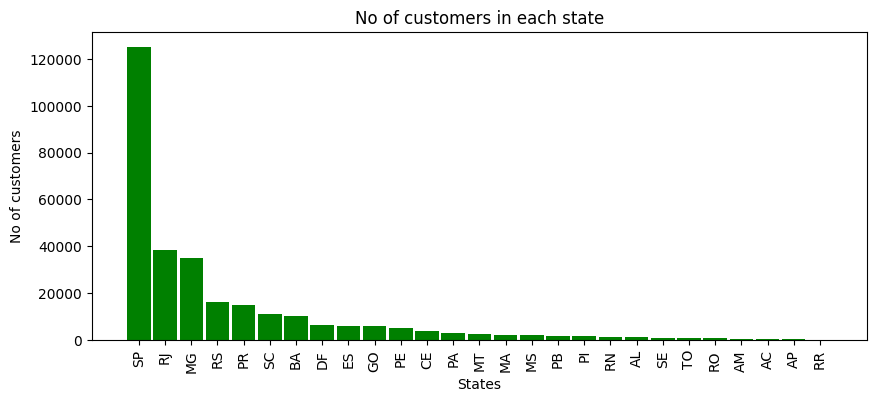

In [8]:
q1='select count(*), customer_state from customers group by customer_state'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=['No Of People','State'])
df=df.sort_values(by='No Of People',ascending=False)
plt.figure(figsize=(10,4))
plt.bar(df['State'],df['No Of People'],width=0.9,color='g')
plt.xticks(rotation=90)
plt.title("No of customers in each state")
plt.ylabel('No of customers')
plt.xlabel('States')
plt.show()

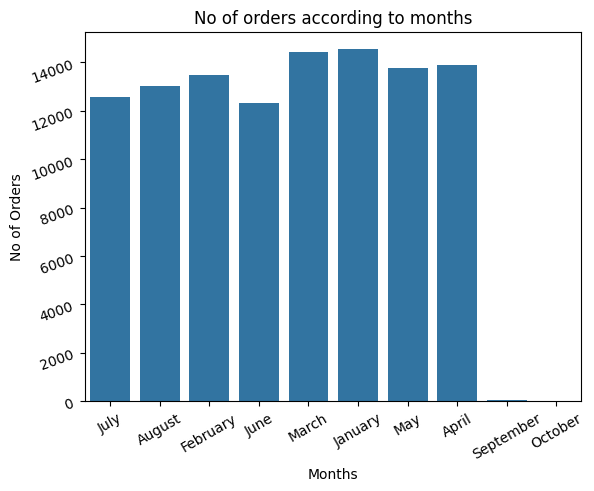

In [9]:
q1='select count(order_id), monthname(order_purchase_timestamp) from orders where year(order_purchase_timestamp)=2018 group by monthname(order_purchase_timestamp)'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=['No of Orders','Months'])
df.head(12)
sns.barplot(x=df['Months'],y=df['No of Orders'])
plt.title("No of orders according to months")
plt.xticks(rotation=30)
plt.yticks(rotation=20)
plt.show()
df.to_csv('export.csv')

# Top 10 percentage of total revenue contributed by each product category.

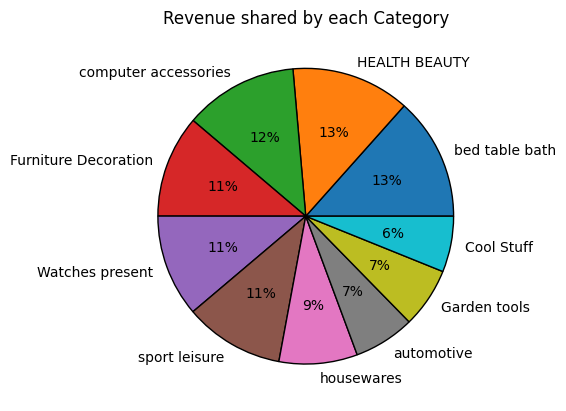

In [10]:
q2='select round((sum(payment_value)/(select sum(payment_value) from payments))*100,2)as sum1, product_category as category from products p join  order_items p1 on p.product_id=p1.product_id join payments  p2 on p1.order_id=p2.order_id group by p.product_category order by sum1 desc limit 10;'
cur.execute(q2)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=['Percentage','Category'])
df.dropna(inplace=True)   #because there exist a null value inside the DataFrame
wedgeprops = {'edgecolor': 'black', 'linewidth': 1}
plt.pie(df['Percentage'], labels=df['Category'],autopct='%1.0f%%',wedgeprops=wedgeprops)
plt.title("Revenue shared by each Category")
plt.show()

# plt.bar(df['Category'],df['Percentage'])
# plt.xlabel('Category')
# plt.ylabel('Percentage')
# plt.xticks(rotation=50)
# plt.title("Revenue percenatage according to catoegory")
# plt.show()

# Average Price of Product related to product_category

In [11]:
q1='select count(order_id),product_category,avg(price)  from products p join order_items o on o.product_id=p.product_id  group by p.product_category;'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt, columns=['No of time product ordered','Category','Price']);
df

,No of time product ordered,Category,Price
0,9670,HEALTH BEAUTY,130.163531
1,8641,sport leisure,114.344285
2,3796,Cool Stuff,167.357969
3,7827,computer accessories,116.513903
4,5991,Watches present,201.135984
...,...,...,...
69,33,flowers,33.637576
70,15,Kitchen portable and food coach,264.568666
71,30,House Comfort 2,25.342333
72,38,CITTE AND UPHACK FURNITURE,114.949473


# Calculate the total revenue generated by each seller, and rank them by revenue (top10)

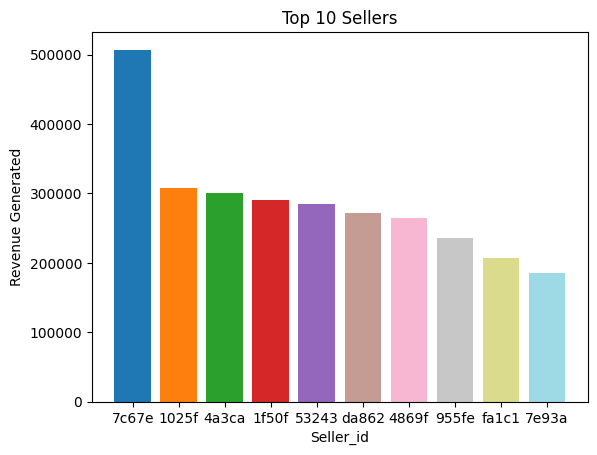

In [12]:
q1='select left(seller_id,5) as sellername, sum(payment_value) as summ  from payments p join order_items o where o.order_id=p.order_id group by o.seller_id order by summ desc limit 10;'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=['Seller_id','Revenue'])
colors = [plt.cm.tab20(i/float(len(df)-1)) for i in range(len(df))]
plt.bar(df['Seller_id'],df['Revenue'] ,color=colors)
plt.title('Top 10 Sellers')
plt.xlabel('Seller_id')
plt.ylabel('Revenue Generated')
plt.show()

# Cumulative sales according to month and year

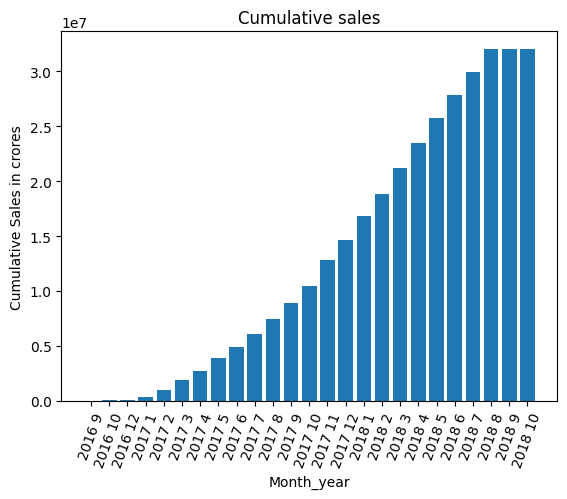

In [13]:
q1='select dat1 ,dat2 ,round((cumu),2),sum(cumu) over(order by dat1,dat2) from (select year(order_purchase_timestamp) as dat1,month(order_purchase_timestamp) as dat2,sum(payment_value) as cumu from orders o join payments p on o.order_id=p.order_id group by dat1,dat2) as a'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=['Year','Month','Sales','Cumulative Sales'])
df=df.round(2)
df['Year']=df['Year'].astype(str)
df['Month']=df['Month'].astype(str)
df['Month']=df['Year']+' '+df['Month']
df.drop(columns=['Year'],inplace=True)
df.rename(columns={'Month':'Month_year'},inplace=True)
df

plt.bar(df['Month_year'],df['Cumulative Sales'])
plt.title('Cumulative sales')
plt.xticks(rotation=70)
plt.xlabel('Month_year')
plt.ylabel('Cumulative Sales in crores')
plt.show()


# Identify the top 3 customers who spent the most money 

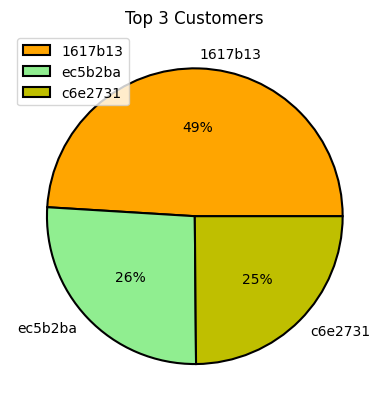

In [14]:
q1='select sum(payment_value) as summ,c.customer_id from orders o join payments p on p.order_id=o.order_id join customers c on o.customer_id=c.customer_id group by c.customer_id  order by summ desc limit 3'
cur.execute(q1)
oupt=cur.fetchall();
df=pd.DataFrame(oupt,columns=['Total Expenditure','Customer_id'])
df['Customer_id']=df['Customer_id'].str.slice(0,7)
df['Total Expenditure']=df['Total Expenditure'].round(0)
wedgeprops = {'edgecolor': 'black', 'linewidth': 1.5}
plt.pie(df['Total Expenditure'],labels=df['Customer_id'],autopct='%1.0f%%',colors=['#FFA500','#90EE90','y'],wedgeprops=wedgeprops)
plt.title('Top 3 Customers')
plt.legend(loc=0)
plt.show()

# Sales according to months

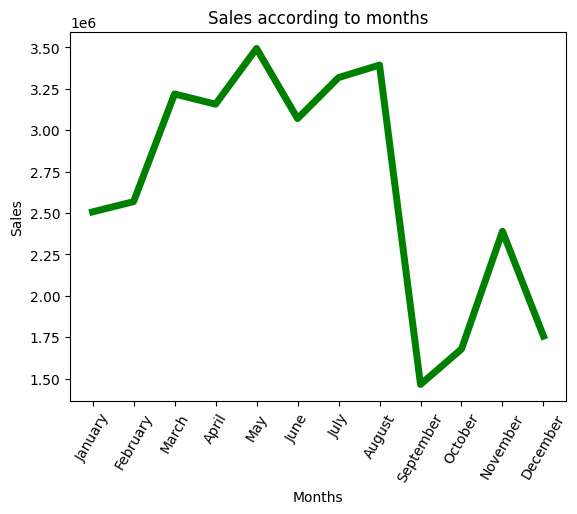

In [15]:
q1='select monthname(order_purchase_timestamp) as mon ,month(order_purchase_timestamp) mon1, sum(payment_value) as sum1  from payments p join orders o on p.order_id=o.order_id group by mon,mon1 order by mon1'
cur.execute(q1)
oupt=cur.fetchall()
df=pd.DataFrame(oupt,columns=['Months','months','Total Sales'])
plt.plot(df['Months'],df['Total Sales'] ,color='green',linewidth=5)
plt.xticks(rotation=60)
plt.title('Sales according to months')
plt.ylabel('Sales')
plt.xlabel('Months')
plt.show()